<a href="https://colab.research.google.com/github/AubLambert/FraudDetection/blob/hieu/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime

from scipy.stats import chi2_contingency
from scipy.stats import spearmanr
from scipy.stats import mode

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm.callback import early_stopping

# Basic Analysis

## Import Data

In [2]:
# Set pandas option to display all columns
pd.set_option('display.max_columns', None)

# Optional: Set the width to avoid line breaks
pd.set_option('display.width', None)

df = pd.read_csv('fraudTrain.csv', on_bad_lines='warn')  # or 'skip' or 'error'
df

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,Hatch,UT,84735,37.7175,-112.4777,258,Geoscientist,1961-11-24,440b587732da4dc1a6395aba5fb41669,1371816728,36.841266,-111.690765,0
1296671,1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,Tuscarora,MD,21790,39.2667,-77.5101,100,"Production assistant, television",1979-12-11,278000d2e0d2277d1de2f890067dcc0a,1371816739,38.906881,-78.246528,0
1296672,1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,High Rolls Mountain Park,NM,88325,32.9396,-105.8189,899,Naval architect,1967-08-30,483f52fe67fabef353d552c1e662974c,1371816752,33.619513,-105.130529,0
1296673,1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,Manderson,SD,57756,43.3526,-102.5411,1126,Volunteer coordinator,1980-08-18,d667cdcbadaaed3da3f4020e83591c83,1371816816,42.788940,-103.241160,0


In [3]:
df = df.drop('Unnamed: 0', axis=1)

## Descriptive Statistics

In [4]:
df.describe()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,4.171920e+17,7.035104e+01,4.880067e+04,3.853762e+01,-9.022634e+01,8.882444e+04,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03
std,1.308806e+18,1.603160e+02,2.689322e+04,5.075808e+00,1.375908e+01,3.019564e+05,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02
min,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00
25%,1.800429e+14,9.650000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00
50%,3.521417e+15,4.752000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00
75%,4.642255e+15,8.314000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00
max,4.992346e+18,2.894890e+04,9.978300e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.371817e+09,6.751027e+01,-6.695090e+01,1.000000e+00


In [5]:
df.shape

(1296675, 22)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop          

In [7]:
df.isnull().sum()

,0
trans_date_trans_time,0
cc_num,0
merchant,0
category,0
amt,0
first,0
last,0
gender,0
street,0
city,0


In [8]:
df.select_dtypes(include=['int64', 'float64']).nunique()

,0
cc_num,983
amt,52928
zip,970
lat,968
long,969
city_pop,879
unix_time,1274823
merch_lat,1247805
merch_long,1275745
is_fraud,2


In [9]:
df.select_dtypes(include=['object', 'category']).nunique()

,0
trans_date_trans_time,1274791
merchant,693
category,14
first,352
last,481
gender,2
street,983
city,894
state,51
job,494


# EDA

In [10]:
# Create a copy for EDA
df_viz = df.copy()

## Data Transformation

### Fraud Rate

In [13]:
fraud_percent = (df['is_fraud'] == 1).sum()/(df.shape[0])

print(f"Fraud Percentage: {fraud_percent * 100:.5f}%")

Fraud Percentage: 0.57887%


### Correlation

#### Numerical correlation

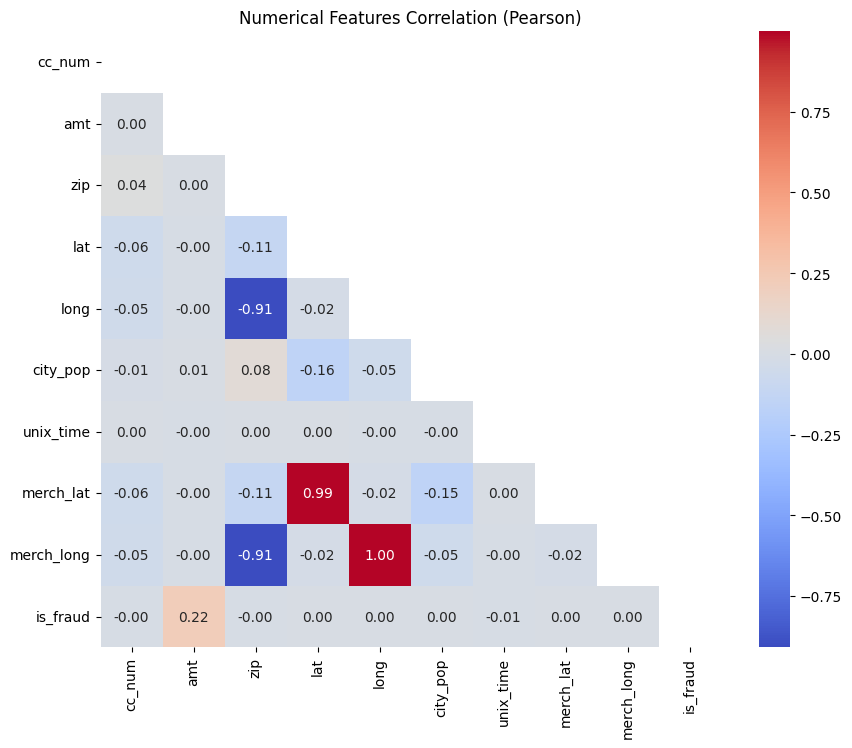

/tmp/ipython-input-170565288.py:28: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




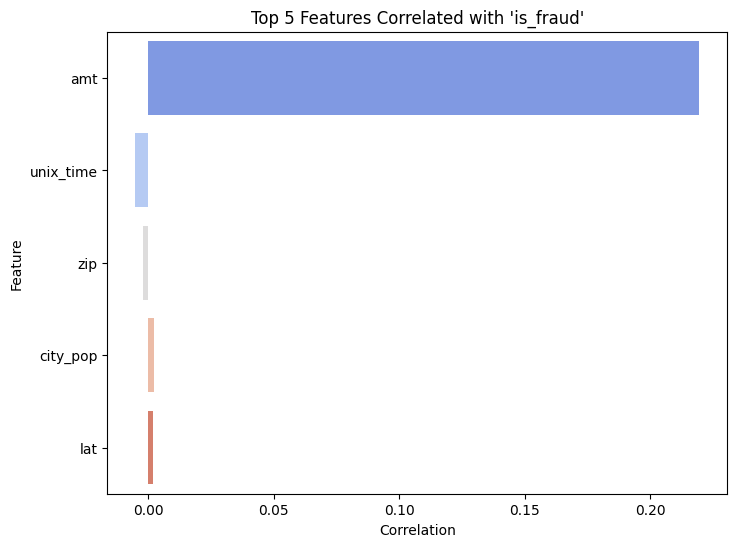

In [105]:
def num_corr(df, target="is_fraud", n=5):
    # Select numerical columns
    num_cols = df.select_dtypes(include=['int32', 'int64', 'float64'])

    # Pearson correlation matrix
    corr_num = num_cols.corr()

    # If target not in numerical columns
    if target not in corr_num.columns:
        raise ValueError(f"Target '{target}' not found among numerical columns.")

    # Extract correlations with target
    corr_target = corr_num[target].drop(target)  # drop self-correlation

    # Get top n absolute correlations
    top_features = corr_target.abs().sort_values(ascending=False).head(n)
    top_features_signed = corr_target.loc[top_features.index]  # keep sign for bar chart

    # --- Plot heatmap of all correlations ---
    mask = np.triu(np.ones_like(corr_num, dtype=bool))
    plt.figure(figsize=(10,8))
    sns.heatmap(corr_num, mask=mask, cmap="coolwarm", annot=True, fmt=".2f", cbar=True)
    plt.title("Numerical Features Correlation (Pearson)")
    plt.show()

    # --- Plot bar chart of top n correlations ---
    plt.figure(figsize=(8,6))
    sns.barplot(x=top_features_signed.values, y=top_features_signed.index, palette="coolwarm")
    plt.title(f"Top {n} Features Correlated with '{target}'")
    plt.xlabel("Correlation")
    plt.ylabel("Feature")
    plt.show()

num_corr(df_viz)

#### Categorical correlation

In [106]:
df_viz_samp = df_viz.drop(["trans_date_trans_time", "dob", "trans_num"], axis=1)

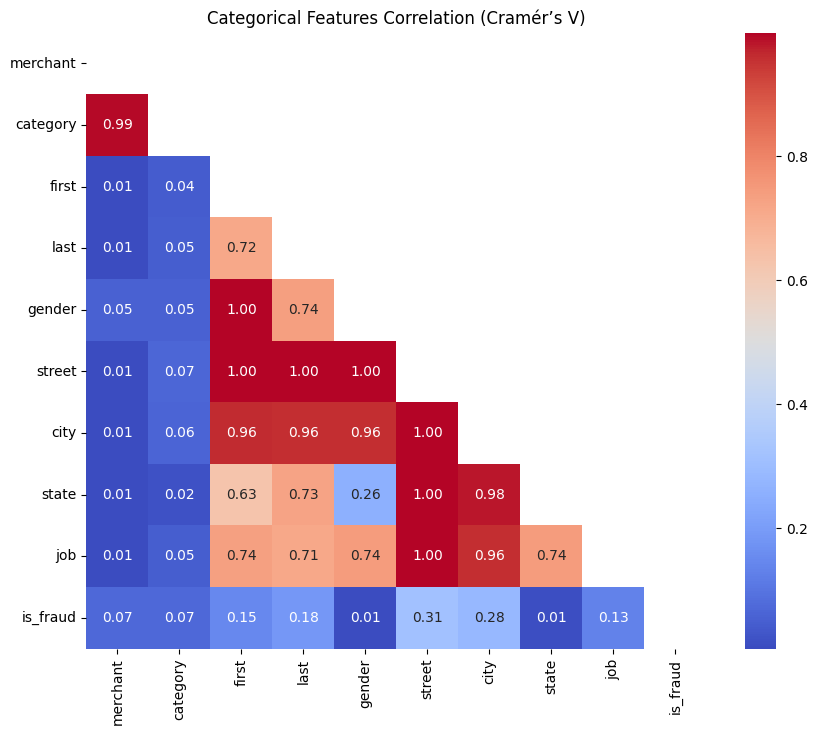

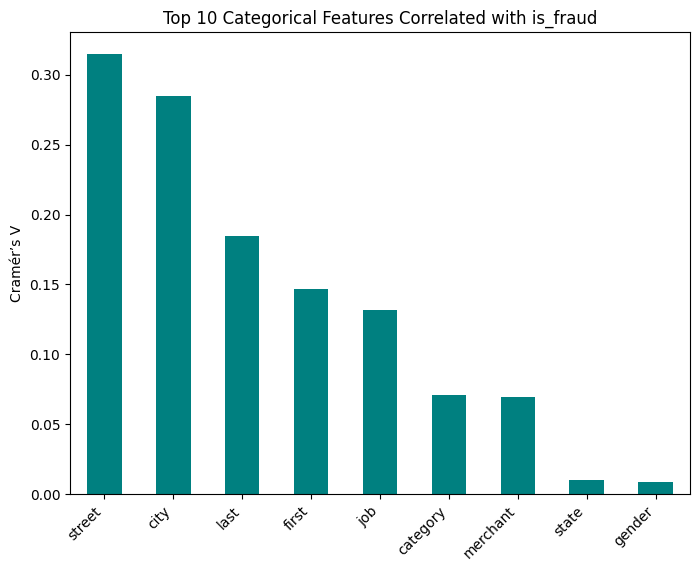

In [107]:
def cat_corr(df, n=10):
    def cramers_v(x, y):
        confusion_matrix = pd.crosstab(x, y)
        chi2 = chi2_contingency(confusion_matrix)[0]
        n_obs = confusion_matrix.sum().sum()
        phi2 = chi2 / n_obs
        r, k = confusion_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n_obs-1))
        rcorr = r - ((r-1)**2) / (n_obs-1)
        kcorr = k - ((k-1)**2) / (n_obs-1)
        return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

    # Sample to reduce computation cost
    df_viz_samp = df.sample(frac=0.1, random_state=42)
    df_viz_samp["is_fraud"] = df_viz_samp["is_fraud"].astype("category")
    cat_cols = df_viz_samp.select_dtypes(include=["object", "category"]).astype("category")

    # Compute Cramér’s V with is_fraud
    corr_with_target = {}
    for c in cat_cols.columns:
        if c != "is_fraud":
            corr_with_target[c] = cramers_v(cat_cols[c], df_viz_samp["is_fraud"])

    # Sort by strength
    sorted_corr = pd.Series(corr_with_target).sort_values(ascending=False)

    # --- Heatmap (all categorical pairs) ---
    corr_cat = pd.DataFrame(np.zeros((len(cat_cols.columns), len(cat_cols.columns))),
                            index=cat_cols.columns, columns=cat_cols.columns)
    for c1 in cat_cols.columns:
        for c2 in cat_cols.columns:
            corr_cat.loc[c1, c2] = cramers_v(cat_cols[c1], cat_cols[c2])

    mask = np.triu(np.ones_like(corr_cat, dtype=bool))
    plt.figure(figsize=(10,8))
    sns.heatmap(corr_cat, mask=mask, cmap="coolwarm", annot=True, fmt=".2f", cbar=True)
    plt.title("Categorical Features Correlation (Cramér’s V)")
    plt.show()

    # --- Bar chart (top-N with is_fraud) ---
    plt.figure(figsize=(8,6))
    sorted_corr.head(n).plot(kind="bar", color="teal")
    plt.title(f"Top {n} Categorical Features Correlated with is_fraud")
    plt.ylabel("Cramér’s V")
    plt.xticks(rotation=45, ha="right")
    plt.show()

cat_corr(df_viz_samp)

### Date and Time Heatmap


#### Transaction

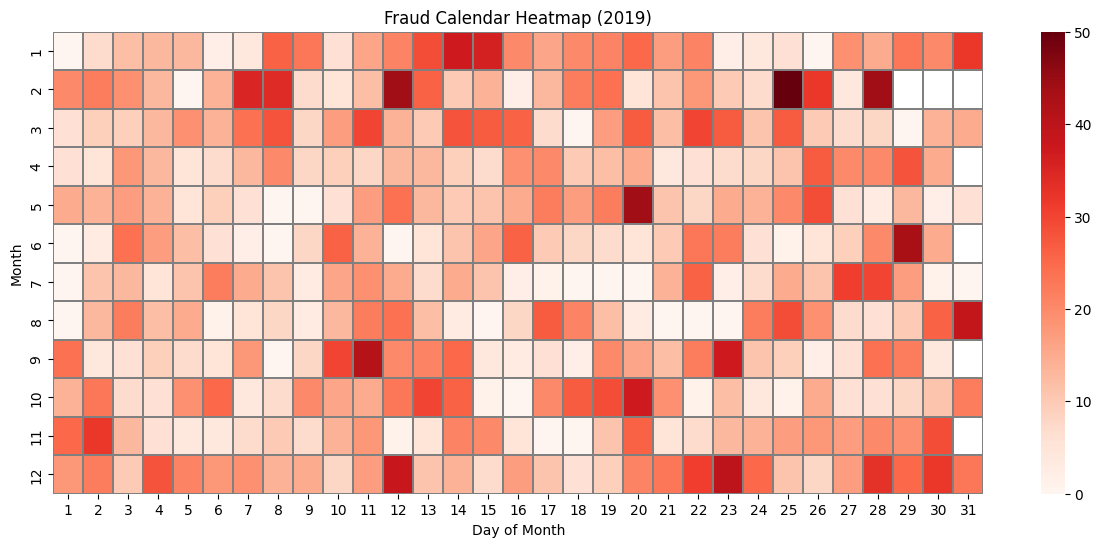

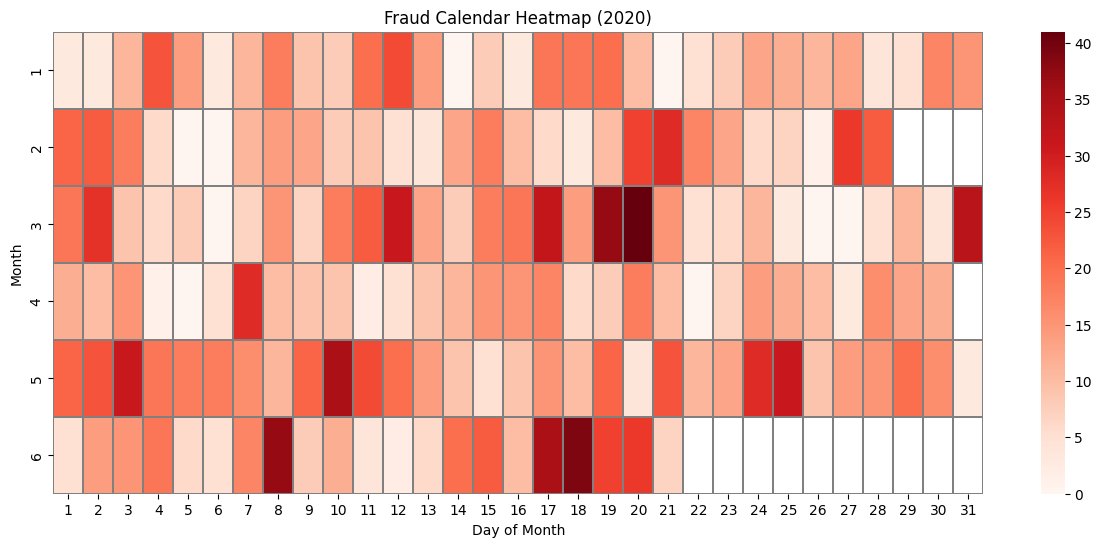

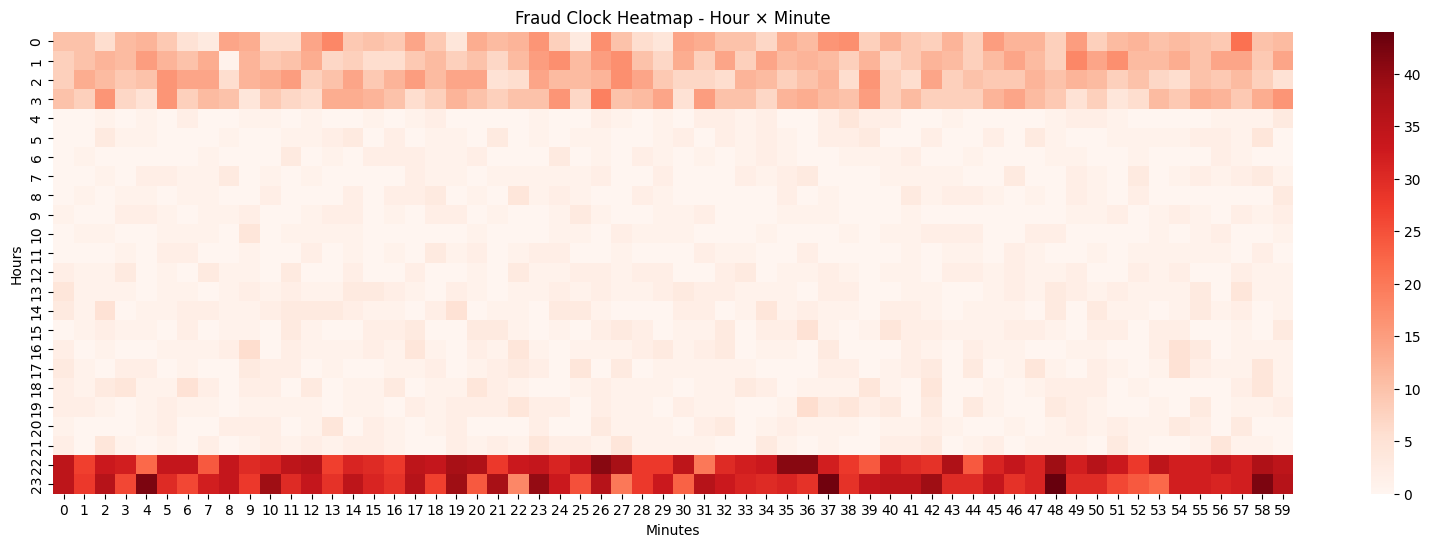

In [143]:
df_viz["trans_date_trans_time"] = pd.to_datetime(df_viz["trans_date_trans_time"])
df_viz["year"] = df_viz["trans_date_trans_time"].dt.year
df_viz["month"] = df_viz["trans_date_trans_time"].dt.month
df_viz["day"] = df_viz["trans_date_trans_time"].dt.day
df_viz["hour"] = df_viz["trans_date_trans_time"].dt.hour
df_viz["minute"] = df_viz["trans_date_trans_time"].dt.minute
df_viz["second"] = df_viz["trans_date_trans_time"].dt.second

# =====================================================
# 1) CALENDAR HEATMAP (Year × Month × Day)
# =====================================================
fraud_calendar = df_viz.groupby(["year","month","day"])["is_fraud"].sum().reset_index()

for yr in sorted(fraud_calendar["year"].unique()):
    pivoted = fraud_calendar[fraud_calendar["year"]==yr].pivot(
        index="month", columns="day", values="is_fraud"
    )

    plt.figure(figsize=(15,6))
    sns.heatmap(pivoted, cmap="Reds", cbar=True, linewidths=0.1, linecolor="grey")
    plt.title(f"Fraud Calendar Heatmap ({yr})")
    plt.xlabel("Day of Month")
    plt.ylabel("Month")
    plt.show()

# =====================================================
# 2) CLOCK HEATMAP (Hour × Minute)
# =====================================================

fraud_clock_min = df_viz.groupby(["hour","minute"])["is_fraud"].sum().reset_index()

pivoted_clock_min = fraud_clock_min.pivot_table(
    index="hour", columns="minute", values="is_fraud", fill_value=0
)

plt.figure(figsize=(20,6))
sns.heatmap(pivoted_clock_min, cmap="Reds", cbar=True)
plt.title("Fraud Clock Heatmap - Hour × Minute")
plt.xlabel("Minutes")
plt.ylabel("Hours")
plt.show()

#### DoB

In [144]:
df_viz["dob"] = pd.to_datetime(df_viz["dob"])
df_viz["dob_year"] = df_viz["dob"].dt.year
df_viz["dob_month"] = df_viz["dob"].dt.month
df_viz["dob_day"] = df_viz["dob"].dt.day


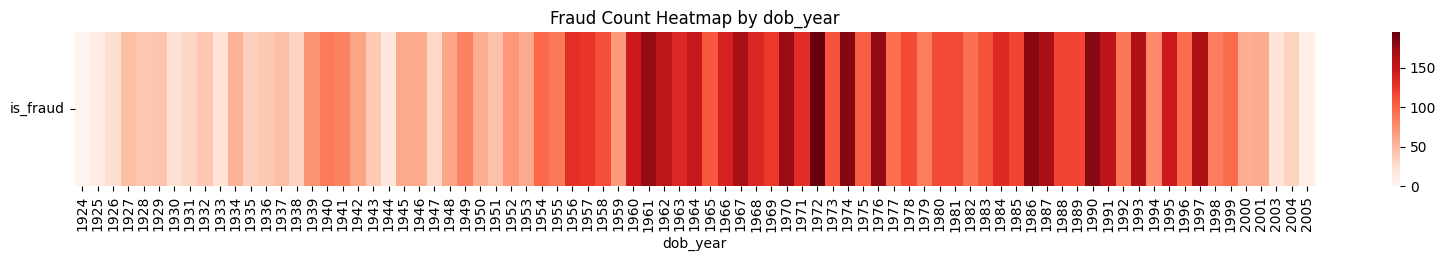

In [114]:
feature_to_target(df_viz, "dob_year")

### Concatenate customer_name

In [118]:
df_viz["customer_name"] = df_viz["first"].str.cat(df_viz["last"], sep=' ')

In [119]:
df_viz["customer_name"].nunique()

973

In [120]:
df_viz = df_viz.drop(["first", "last"], axis=1)

### Split merchant prefix

In [121]:
df_viz["merchant"].str.startswith("fraud_").sum()

np.int64(1296675)

### Split street components

In [122]:
splits = df_viz["street"].str.split(" ", expand=True)

# Assign to new columns sequentially
df_viz["str_number"]    = splits[0]
df_viz["str_name"]      = splits[1]
df_viz["str_type"]      = splits[2]
df_viz["building_type"] = splits[3]
df_viz["room_number"]   = splits[4]

df_viz = df_viz.drop('street', axis=1)

In [123]:
df_viz.nunique()

,0
trans_date_trans_time,1274791
cc_num,983
merchant,693
category,14
amt,52928
gender,2
city,894
state,51
zip,970
lat,968


### Split zip prefix

In [125]:
df_viz["zip"] = df_viz["zip"].astype(str).str.zfill(5)

# Extract first 3 digits (ZIP prefix / metro area)
df_viz["zip_prefix"] = df_viz["zip"].str[:3]

In [126]:
df_viz["zip_prefix"].nunique()

526

In [128]:
df_viz["zip_prefix"].astype(int)
df_viz = df_viz.drop("zip", axis=1)

### Calculate distance (km) between merchants and customers

In [129]:
def haversine_vectorized(lat1, lon1, lat2, lon2):
    # Convert to radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Earth radius in kilometers
    return r * c

# Example usage with your DataFrame df
df_viz['distance_km'] = haversine_vectorized(
    df_viz['lat'], df_viz['long'], df_viz['merch_lat'], df_viz['merch_long']
)

### Calculating age

In [146]:
df_viz["age"] = df_viz["year"] - df_viz["dob_year"]

### Drop datetime columns (trans_date_trans_time, dob), trans_num

#### Drop columns

In [147]:
# Keep the rest for analysis
df_viz_samp = df_viz.drop(["dob", "trans_num"], axis=1)

### Correlation after transformation

In [149]:
target_col = "is_fraud"   # replace with your target column name

# Move target column to the end
def reorder(df):
    cols = [c for c in df.columns if c != target_col] + [target_col]
    df = df[cols]
    return df

reorder(df_viz_samp)

,trans_date_trans_time,cc_num,merchant,category,amt,gender,city,state,lat,long,city_pop,job,merch_lat,merch_long,year,month,day,hour,minute,second,dob_year,dob_month,dob_day,generation,customer_name,str_number,str_name,str_type,building_type,room_number,zip_prefix,distance_km,age,n_cc,unix_time,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,Moravian Falls,NC,36.0788,-81.1781,3495,Psychologist,36.011293,-82.048315,2019,1,1,0,0,18,1988,3,9,Millennial,Jennifer Banks,561,Perry,Cove,House,None,286,78.597568,31,1,1546300818,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,Orient,WA,48.8878,-118.2105,149,Special educational needs teacher,49.159047,-118.186462,2019,1,1,0,0,44,1978,6,21,Gen X,Stephanie Gill,43039,Riley,Greens,Suite,393,991,30.212176,41,1,1546300844,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,M,Malad City,ID,42.1808,-112.2620,4154,Nature conservation officer,43.150704,-112.154481,2019,1,1,0,0,51,1962,1,19,Baby Boomer,Edward Sanchez,594,White,Dale,Suite,530,832,108.206083,57,1,1546300851,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,Boulder,MT,46.2306,-112.1138,1939,Patent attorney,47.034331,-112.561071,2019,1,1,0,1,16,1967,1,12,Gen X,Jeremy White,9443,Cynthia,Court,Apt.,038,596,95.673231,52,1,1546300876,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,M,Doe Hill,VA,38.4207,-79.4629,99,Dance movement psychotherapist,38.674999,-78.632459,2019,1,1,0,3,6,1986,3,28,Millennial,Tyler Garcia,408,Bradley,Rest,House,None,244,77.556744,33,1,1546300986,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,M,Hatch,UT,37.7175,-112.4777,258,Geoscientist,36.841266,-111.690765,2020,6,21,12,12,8,1961,11,24,Baby Boomer,Erik Patterson,162,Jessica,Row,Apt.,072,847,119.752136,59,1,1592741528,0
1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,M,Tuscarora,MD,39.2667,-77.5101,100,Production assistant,38.906881,-78.246528,2020,6,21,12,12,19,1979,12,11,Gen X,Jeffrey White,8617,Holmes,Terrace,Suite,651,217,75.104085,41,1,1592741539,0
1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,M,High Rolls Mountain Park,NM,32.9396,-105.8189,899,Naval architect,33.619513,-105.130529,2020,6,21,12,12,32,1967,8,30,Gen X,Christopher Castaneda,1632,Cohen,Drive,Suite,639,883,99.047734,53,1,1592741552,0
1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,M,Manderson,SD,43.3526,-102.5411,1126,Volunteer coordinator,42.788940,-103.241160,2020,6,21,12,13,36,1980,8,18,Gen X,Joseph Murray,42933,Ryan,Underpass,House,None,577,84.627652,40,1,1592741616,0


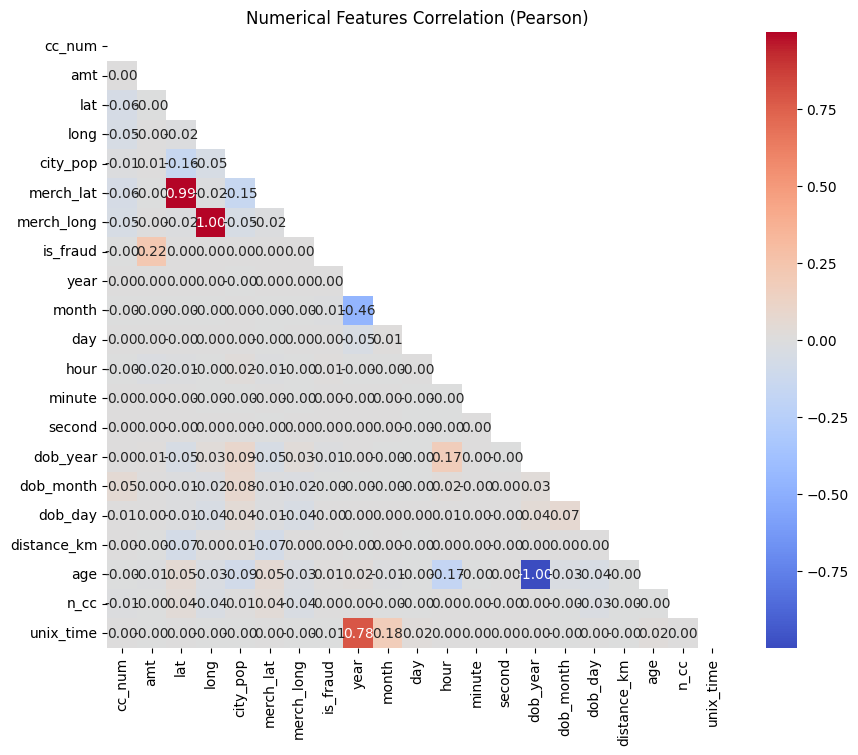

/tmp/ipython-input-170565288.py:28: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




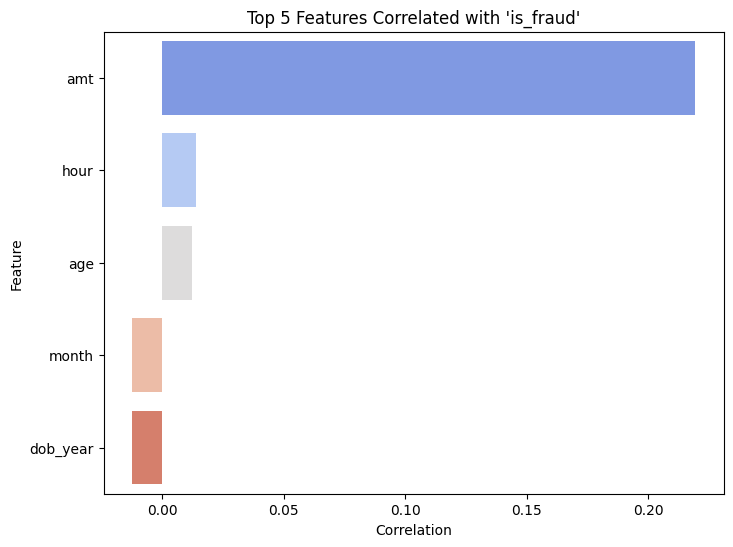

In [140]:
num_corr(df_viz_samp)

In [141]:
df_viz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 38 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   trans_date_trans_time  1296675 non-null  datetime64[ns]
 1   cc_num                 1296675 non-null  int64         
 2   merchant               1296675 non-null  object        
 3   category               1296675 non-null  object        
 4   amt                    1296675 non-null  float64       
 5   gender                 1296675 non-null  object        
 6   city                   1296675 non-null  object        
 7   state                  1296675 non-null  object        
 8   lat                    1296675 non-null  float64       
 9   long                   1296675 non-null  float64       
 10  city_pop               1296675 non-null  int64         
 11  job                    1296675 non-null  object        
 12  dob                    12966

## Relationship Analysis

### Fraud Rate by Category Spending: Keep

/tmp/ipython-input-3979180993.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(fraud_by_cat_amt["category"], rotation=45, ha="right")


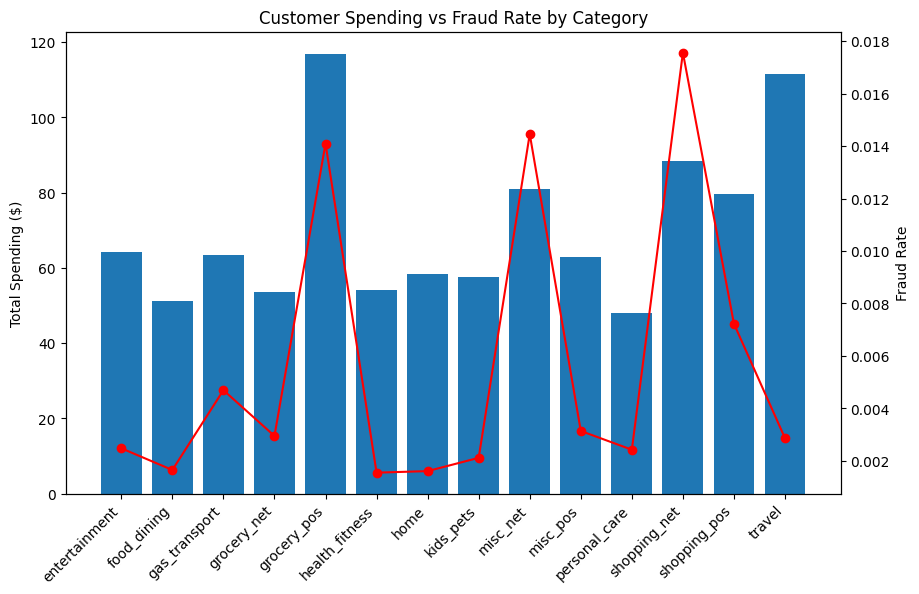

In [55]:
fraud_by_cat_amt = (
    df_viz.groupby("category")
    .agg(
        total_spent=("amt", "mean"),
        fraud_cases=("is_fraud", "sum"),
        total_transactions=("is_fraud", "count")
    )
    .reset_index()
)

fraud_by_cat_amt["fraud_rate"] = (
    fraud_by_cat_amt["fraud_cases"] / fraud_by_cat_amt["total_transactions"]
)

fig, ax1 = plt.subplots(figsize=(10,6))

# Bar for spending
ax1.bar(fraud_by_cat_amt["category"], fraud_by_cat_amt["total_spent"])
ax1.set_ylabel("Total Spending ($)")
ax1.set_xticklabels(fraud_by_cat_amt["category"], rotation=45, ha="right")

# Second axis for fraud rate
ax2 = ax1.twinx()
ax2.plot(fraud_by_cat_amt["category"], fraud_by_cat_amt["fraud_rate"], color="red", marker="o")
ax2.set_ylabel("Fraud Rate")

plt.title("Customer Spending vs Fraud Rate by Category")
plt.show()

### Fraud Cases by State: Keep with Total Amt of Transactions by State

In [57]:
df_state = df_viz.groupby("state")["is_fraud"].sum().reset_index()

fig = px.choropleth(df_state,
                    locations='state',
                    locationmode='USA-states',
                    color='is_fraud',
                    scope="usa",
                    color_continuous_scale="Reds",
                    labels={'is_fraud':'Fraud Rate'}
)
fig.update_layout(title_text="US Fraud Rate by State", geo_scope='usa')
fig.show()

### Total Amount of Transactions by State

In [58]:
state_amt = df_viz.groupby("state").agg(
    total_amt=("amt", "sum"),
    total_transactions=("amt", "count")
).reset_index()

fig = px.choropleth(state_amt,
                    locations='state',
                    locationmode='USA-states',
                    color='total_amt',
                    scope="usa",
                    color_continuous_scale="Reds",
                    labels={'total_amt':'Total Amount'})

fig.update_layout(title_text="US Total Amount of Transactions by State", geo_scope='usa')
fig.show()

### Fraud Rate by Gender: Keep

In [62]:
fraud_rate_gender = (
    df_viz.groupby("gender")["is_fraud"]
    .agg(["sum", "count"])
    .reset_index()
)

fraud_rate_gender["fraud_rate"] = (
    fraud_rate_gender["sum"] * 100 / fraud_rate_gender["count"]
)

print(fraud_rate_gender)

  gender   sum   count  fraud_rate
0      F  3735  709863    0.526158
1      M  3771  586812    0.642625


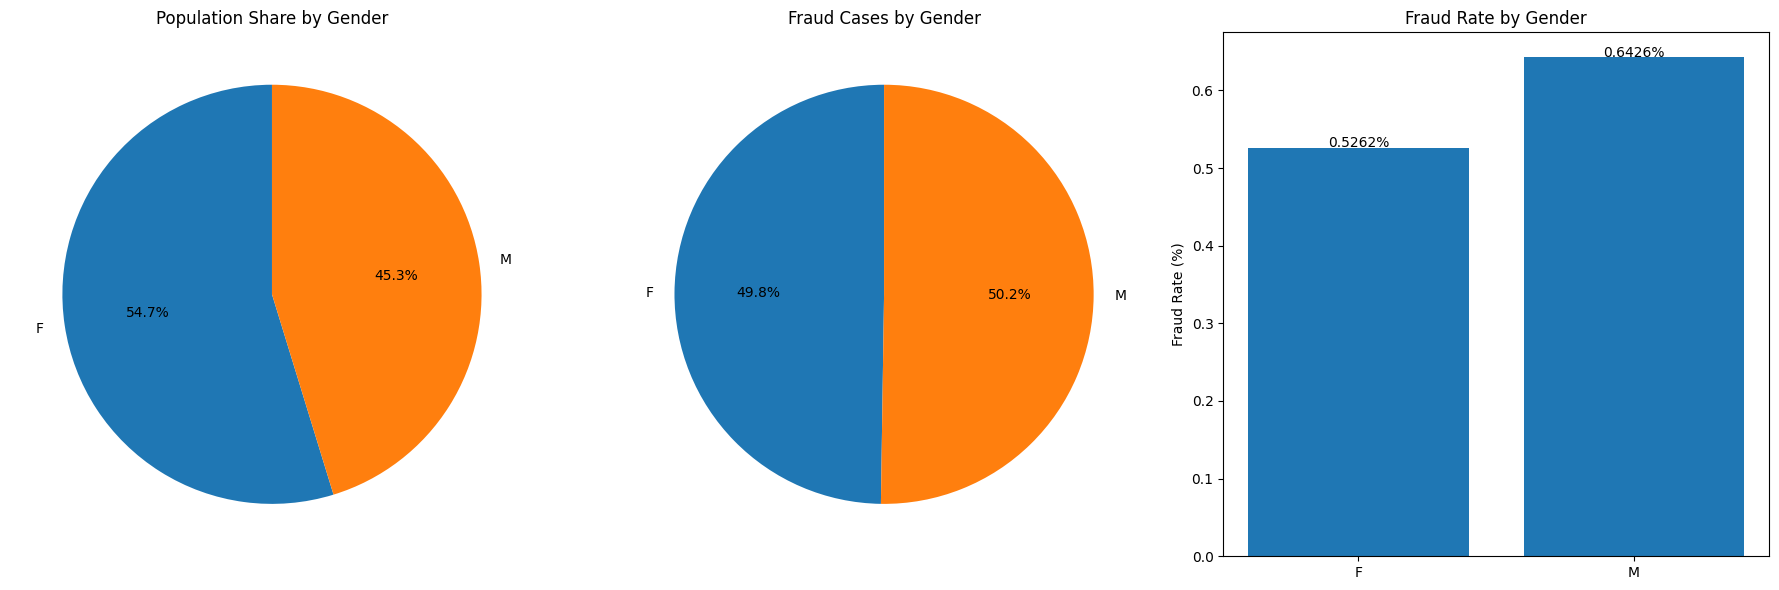

In [63]:
# --- Data prep ---
# Population distribution
pop_share = fraud_rate_gender.set_index("gender")["count"]

# Fraud case distribution
fraud_cases = fraud_rate_gender.set_index("gender")["sum"]

# Fraud rate (% of each gender)
fraud_rate = fraud_rate_gender.set_index("gender")["fraud_rate"]

# --- Plot ---
fig, axes = plt.subplots(1, 3, figsize=(18,6))

# 1. Population share
axes[0].pie(pop_share, labels=pop_share.index, autopct="%.1f%%", startangle=90)
axes[0].set_title("Population Share by Gender")

# 2. Fraud case share
axes[1].pie(fraud_cases, labels=fraud_cases.index, autopct="%.1f%%", startangle=90)
axes[1].set_title("Fraud Cases by Gender")

# 3. Fraud rate (better as bar than pie because values are very small)
axes[2].bar(fraud_rate.index, fraud_rate.values)
axes[2].set_title("Fraud Rate by Gender")
axes[2].set_ylabel("Fraud Rate (%)")
for i, v in enumerate(fraud_rate.values):
    axes[2].text(i, v + 0.001, f"{v:.4f}%", ha="center")  # show 4 decimals since ~0.05%

plt.tight_layout()
plt.show()

### Amount vs fraud: Keep

In [64]:
df.groupby("is_fraud")["amt"].describe()

,count,mean,std,min,25%,50%,75%,max
is_fraud,,,,,,,,
0,1289169.0,67.667110,154.007971,1.00,9.6100,47.280,82.540,28948.90
1,7506.0,531.320092,390.560070,1.06,245.6625,396.505,900.875,1376.04


In [67]:
# --- Compute median amount ---
median_amt = df_viz["amt"].median()

# --- Count high-amount frauds per customer (without modifying df) ---
high_amt_fraud_counts = df_viz.loc[(df_viz["amt"] > median_amt) & (df_viz["is_fraud"] == 1)]
customer_counts = high_amt_fraud_counts.groupby("customer_name").size().reset_index(name="num_high_amt_fraud")

# Average number of high-amount frauds per customer
avg_high_amt_fraud_per_customer = customer_counts["num_high_amt_fraud"].mean()

# Total number of high-amount transactions
total_high_amt = df_viz["amt"].loc[df_viz["amt"] > median_amt].mean()

# Compute ratio
ratio = avg_high_amt_fraud_per_customer*100 / total_high_amt

print(f"Probability that a transaction with higher than median amount is fradulent: {ratio:.2f}%")

Probability that a transaction with higher than median amount is fradulent: 6.37%


In [68]:
from scipy.stats import pointbiserialr
corr, pval = pointbiserialr(df["amt"], df["is_fraud"])
print(corr, pval)

0.2194038889588689 0.0


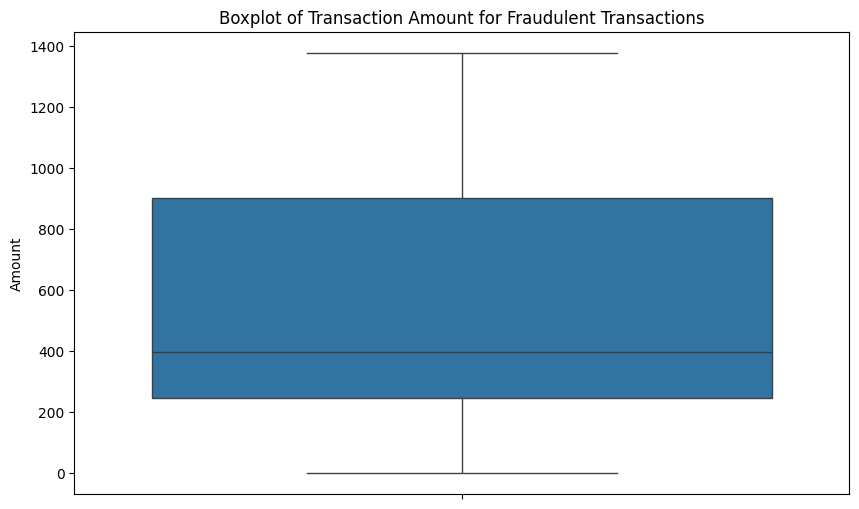

In [69]:
# Filter the DataFrame to include only fraudulent transactions
fraud_df = df_viz[df_viz['is_fraud'] == 1]

plt.figure(figsize=(10, 6))
sns.boxplot(y=fraud_df['amt'])
plt.title('Boxplot of Transaction Amount for Fraudulent Transactions')
plt.ylabel('Amount')
plt.show()

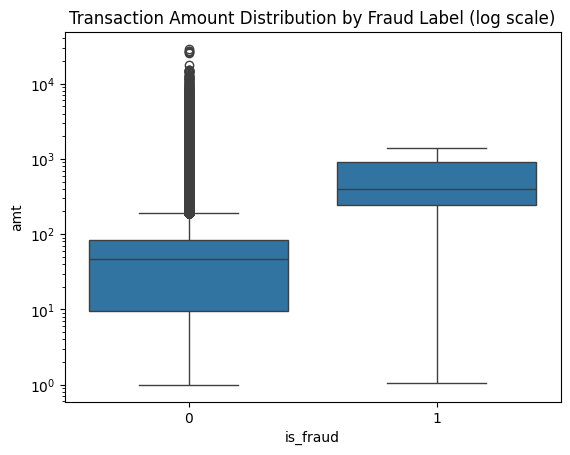

/tmp/ipython-input-3897882132.py:8: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



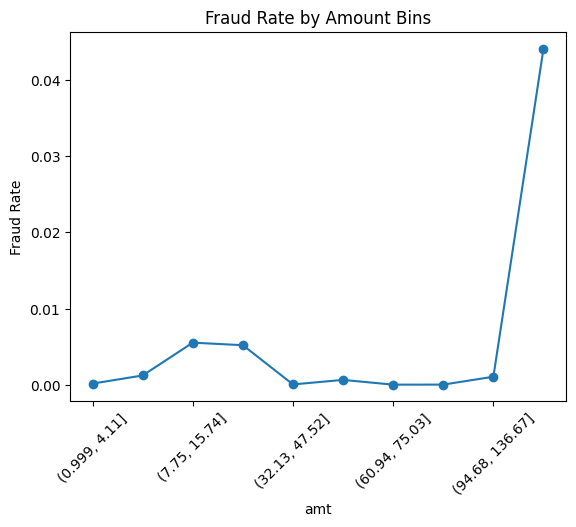

Correlation: 0.2194038889588689 p-value: 0.0


In [70]:
sns.boxplot(x="is_fraud", y="amt", data=df_viz)
plt.yscale("log")
plt.title("Transaction Amount Distribution by Fraud Label (log scale)")
plt.show()

# --- Fraud rate by amount bins (quantiles) ---
amount_bins = pd.qcut(df_viz["amt"], q=10)  # 10 quantile bins
fraud_rate = df_viz.groupby(amount_bins)["is_fraud"].mean()

fraud_rate.plot(kind="line", marker="o", title="Fraud Rate by Amount Bins")
plt.ylabel("Fraud Rate")
plt.xticks(rotation=45)
plt.show()

# --- Point-biserial correlation ---
corr, pval = pointbiserialr(df_viz["amt"], df_viz["is_fraud"])
print("Correlation:", corr, "p-value:", pval)

### Analyze fraud rate by time difference: Keep


In [71]:
df_viz_date = df_viz.sort_values(by=["cc_num", "trans_date_trans_time"])
df_viz_date["time_delta"] = df_viz_date.groupby("cc_num")["trans_date_trans_time"].diff().dt.total_seconds() / 3600

/tmp/ipython-input-3246032655.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



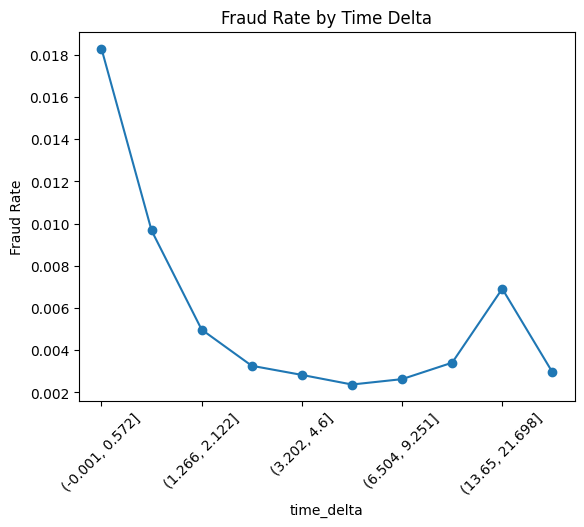

In [72]:
# Create quantile bins on the fly
time_bins = pd.qcut(df_viz_date["time_delta"].dropna(), q=10)

# Group by bins and compute fraud rate
fraud_rate_by_bin = df_viz_date.groupby(time_bins)["is_fraud"].mean()

# Plot
fraud_rate_by_bin.plot(kind="line", marker="o", title="Fraud Rate by Time Delta")
plt.ylabel("Fraud Rate")
plt.xticks(rotation=45)
plt.show()

### Phan cua Dat: Keep


In [150]:
df_viz_date = pd.concat([df_viz_date, df_dob], axis=1)

# oldest_dob = df_viz_dob['dob'].min()
# print(f"The oldest person in the dataset was born on: {oldest_dob.strftime('%Y-%m-%d')}")

In [153]:
def categorize_generation(year):
    if 1924 <= year <= 1945:
        return "The Silent Generation: 1924-1945"
    elif 1946 <= year <= 1964:
        return "Baby Boomer: 1946-1964"
    elif 1965 <= year <= 1979:
        return "Gen X: 1965-1979"
    elif 1980 <= year <= 1994:
        return "Millennials: 1980-1994"
    else:
        return "Gen Z: 1995+"

df_viz['generations'] = df_viz['dob_year'].apply(categorize_generation)

In [155]:
fraud_customers = (
    df_viz[df_viz["is_fraud"] == 1]
    .groupby("generations")["customer_name"]
    .nunique()
    .reset_index(name="n_customers_with_fraud")
)

total_customers = (
    df_viz.groupby("generations")["customer_name"]
    .nunique()
    .reset_index(name="n_customers")
)

fraud_by_generation = fraud_customers.merge(total_customers, on="generations")

count_fraud_generation = fraud_by_generation.copy()

fraud_by_generation["fraud_ratio"] = (
    fraud_by_generation["n_customers_with_fraud"]
    / fraud_by_generation["n_customers"]
)

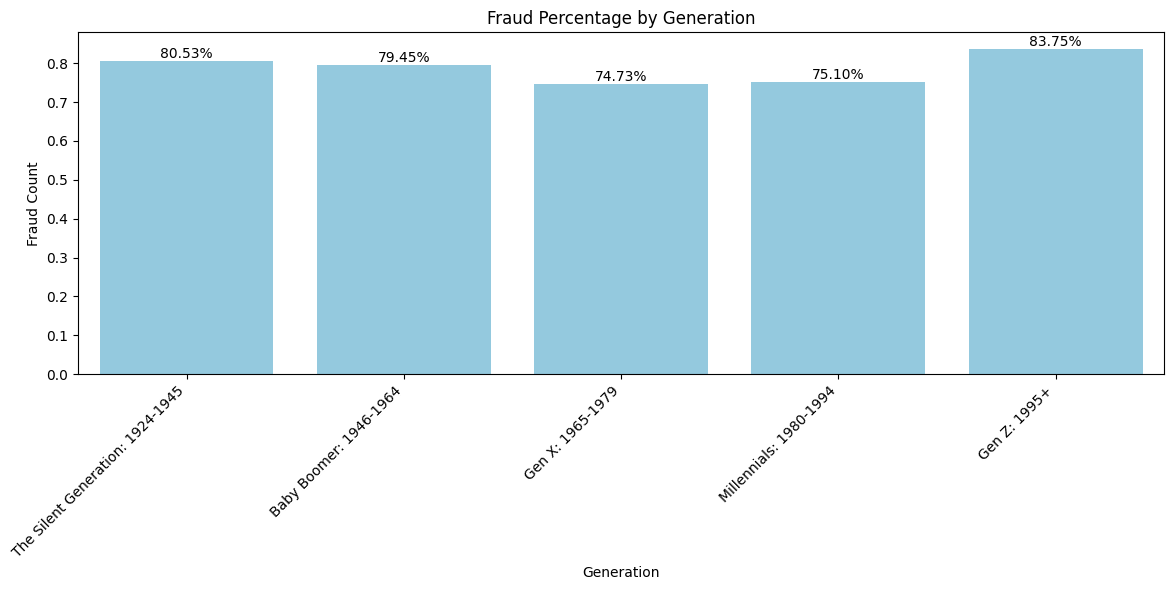

In [156]:
# Define the desired order of generations
generation_order = [
    "The Silent Generation: 1924-1945",
    "Baby Boomer: 1946-1964",
    "Gen X: 1965-1979",
    "Millennials: 1980-1994",
    "Gen Z: 1995+"
]

# # Convert 'generation' to a categorical type with the specified order
fraud_by_generation['generations'] = pd.Categorical(
    fraud_by_generation['generations'], categories=generation_order, ordered=True
)

# Sort by the categorical 'generation' column
fraud_by_generation = fraud_by_generation.sort_values('generations')

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=fraud_by_generation,
    x='generations',
    y='fraud_ratio',
    color='skyblue'
)

# Add ratio labels on top of bars (as %)
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.2%}",  # format as percentage
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center", va="bottom",
        fontsize=10, color="black"
    )

plt.title("Fraud Percentage by Generation")
plt.xlabel("Generation")
plt.ylabel("Fraud Count")
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.tight_layout()
plt.show()

# Data Preprocessing

## Split datetime

### Split transaction datetime

In [ ]:
df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"])
df["year"] = df["trans_date_trans_time"].dt.year
df["month"] = df["trans_date_trans_time"].dt.month
df["day"] = df["trans_date_trans_time"].dt.day
df["hour"] = df["trans_date_trans_time"].dt.hour
df["minute"] = df["trans_date_trans_time"].dt.minute
df["second"] = df["trans_date_trans_time"].dt.second

### Split DoB

In [ ]:
df["dob"] = pd.to_datetime(df["dob"])
df["dob_year"] = df["dob"].dt.year
df["dob_month"] = df["dob"].dt.month
df["dob_day"] = df["dob"].dt.day

## Flag fraud time

In [ ]:
# Create binary feature
df["fraud_doubt_1"] = df["hour"].apply(
    lambda h: 1 if (h >= 22 or h <= 3) else 0
)

In [ ]:
# df["time_delta"] = (
#     df["trans_date_trans_time"] - df.groupby("cc_num")["trans_date_trans_time"].shift(1)
# ).dt.total_seconds() / 3600

## Generation

In [ ]:
df["generation"] = df["dob_year"].apply(assign_generation)

## Concat customer_name

In [ ]:
df["customer_name"] = df["first"].str.cat(df["last"], sep=' ')

## Split street

In [ ]:
splits = df["street"].str.split(" ", expand=True)

# Assign to new columns sequentially
df["str_number"]    = splits[0]
df["str_name"]      = splits[1]
df["str_type"]      = splits[2]
df["building_type"] = splits[3]
df["room_number"]   = splits[4]

df = df.drop('street', axis=1)

In [ ]:
df["building_type"] = df["building_type"].replace({None: "House"})

## Split zip prefix

In [ ]:
df["zip"] = df["zip"].astype(str).str.zfill(5)

# Extract first 3 digits (ZIP prefix / metro area)
df["zip_prefix"] = df["zip"].str[:3]
df["zip_prefix"] = df["zip_prefix"].astype(int)

## Overwrite job

In [ ]:
df["job"] = df["job"].str.split(",").str[0].str.strip()

## Calculating age

In [ ]:
df["age"] = df["year"] - df["dob_year"]

## Number of cc per customer

In [ ]:
df["n_cc"] = df.groupby("customer_name")["cc_num"].transform("nunique")

## Rewrite unix_time

In [ ]:
df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"])

# Create a new column with unix_time (seconds since epoch)
df["unix_time"] = df["trans_date_trans_time"].astype(int) // 10**9

## Other

In [ ]:
from scipy.stats import skew

# Select only numeric features
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Compute skewness for each numeric column
skewness = df[num_cols].apply(lambda x: skew(x.dropna()))
skewness = skewness.sort_values(ascending=False)

print(skewness)

amt              42.277825
is_fraud         13.029107
n_cc              7.858677
city_pop          5.593847
cc_num            2.851876
fraud_doubt_1     1.249177
zip_prefix        0.079813
unix_time         0.010313
merch_lat        -0.181915
lat              -0.186027
merch_long       -1.146959
long             -1.150106
dtype: float64


In [ ]:
# from sklearn.preprocessing import PowerTransformer

# Log transform (simple, effective for right-skewed data)
df["amt"] = np.log1p(df["amt"])   # log(amt+1)

# # OR: Yeo-Johnson (handles zero/negative too)
# pt = PowerTransformer(method="yeo-johnson")
# df["amt_yj"] = pt.fit_transform(df[["amt"]])

In [ ]:
df = df.sort_values(by=["cc_num", "trans_date_trans_time"])
df["time_delta"] = df.groupby("cc_num")["trans_date_trans_time"].diff().dt.total_seconds() / 3600

In [ ]:
# # Haversine function assumed to be defined
# street_thresh_hr = 10 / 60  # 10 min → 0.1667 hr
# city_thresh_hr = 30 / 60    # 30 min → 0.5 hr
# avg_speed = 90              # km/h

# # Compute distance and speed
# distance = haversine_vectorized(
#     df.groupby("cc_num")["lat"].shift(1),
#     df.groupby("cc_num")["long"].shift(1),
#     df["lat"],
#     df["long"]
# )
# df["speed_kmh"] = distance / df["time_delta"].replace(0, np.nan)

# # Flags
# df["str_shifted"] = ((df["str_name"] != df.groupby("cc_num")["str_name"].shift(1)) &
#                               (df["time_delta"] < street_thresh_hr)).astype(int)

# df["city_shifted"] = ((df["city_pop"] != df.groupby("cc_num")["city_pop"].shift(1)) &
#                                (df["time_delta"] < city_thresh_hr)).astype(int)

# df["speed_flag"] = ((df["speed_kmh"] > avg_speed) &
#                              ((df["str_shifted"] == 1) | (df["city_shifted"] == 1))).astype(int)

In [ ]:
df["merchant_freq"] = df["merchant"].map(df["merchant"].value_counts())

# Average transaction amount per merchant
merchant_avg = df.groupby("merchant")["amt"].mean()
df["merchant_avg_amt"] = df["merchant"].map(merchant_avg)

In [ ]:
df["state_freq"] = df["state"].map(df["state"].value_counts())
df["job_freq"] = df["job"].map(df["job"].value_counts())
df["transaction_freq"] = df["customer_name"].map(df["customer_name"].value_counts())
df["strtype_freq"] = df["str_type"].map(df["str_type"].value_counts())
df["n_house"] = (
    df.groupby("customer_name")["str_name"].transform("nunique")
)

In [ ]:
# y_true = df_viz_date["is_fraud"]
# y_pred = df_viz_date["str_shifted"]

# cm = confusion_matrix(y_true, y_pred)
# disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
# disp.plot(cmap="Blues")
# plt.title("Confusion Matrix - Street Shifted")
# plt.show()

In [ ]:
# y_pred = df_viz_date["city_shifted"]

# cm = confusion_matrix(y_true, y_pred)
# disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
# disp.plot(cmap="Greens")
# plt.title("Confusion Matrix - City Shifted")
# plt.show()

In [ ]:
# y_pred = df_viz_date["speed_flag"]

# cm = confusion_matrix(y_true, y_pred)
# disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
# disp.plot(cmap="Reds")
# plt.title("Confusion Matrix - Speed Flag")
# plt.show()

In [ ]:
# customer_stats = df.groupby("customer_name").agg(
#     total_transactions=("trans_num", "count"),
#     total_amt=("amt", "sum")
# ).reset_index()

# median_transactions = customer_stats["total_transactions"].median()
# median_amt = customer_stats["total_amt"].median()

# customer_stats["fraud_doubt_4"] = np.where(
#     (customer_stats["total_transactions"] <= median_transactions) &
#     (customer_stats["total_amt"] <= median_amt),
#     1,  # flagged as suspicious
#     0   # not flagged
# )

# df = df.merge(
#     customer_stats[["customer_name", "fraud_doubt_4"]],
#     on="customer_name",
#     how="left"
# )

In [ ]:
# y_true = df["is_fraud"]
# y_pred = df["fraud_doubt_2"]

# cm = confusion_matrix(y_true, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
# disp.plot(cmap="Blues")
# plt.title("Confusion Matrix - Fraud Doubt 2")
# plt.show()

In [ ]:
# # Compute average time delta per category
# category_avg_delta = df.groupby("category")["time_delta"].mean().rename("avg_time_delta")

# # Merge back
# df = df.merge(category_avg_delta, on="category", how="left")

# # Create fraud_doubt_3: flag if time_delta < avg for that category
# df["fraud_doubt_1"] = (df["time_delta"] < df["avg_time_delta"]).astype(int)

In [ ]:
class FraudDoubt2:
    def __init__(self):
        self.avg_time_per_category = None

    def fit(self, df):
        self.avg_time_per_category = (
            df.groupby("category")["time_delta"].mean()
        ).to_dict()
        return self

    def transform(self, df):
        df["avg_time_cat"] = df["category"].map(self.avg_time_per_category)
        df["fraud_doubt_2"] = (df["time_delta"] < df["avg_time_cat"]).astype(int)
        return df

In [ ]:
flag2 = FraudDoubt2().fit(df)
df = flag2.transform(df)

In [ ]:
# # True labels
# y_true = df["is_fraud"]

# # Predictions from the feature
# y_pred = df["fraud_doubt_2"]

# # Compute confusion matrix
# cm = confusion_matrix(y_true, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
# disp.plot(cmap="Blues")
# plt.title("Confusion Matrix - Fraud Doubt 3 (Fast Transaction)")
# plt.show()

In [ ]:
# # Compute mode per category
# category_mode_str_name = df.groupby("category")["str_name"].agg(lambda x: x.mode()[0]).rename("mode_str_name")

# # Merge back
# df = df.merge(category_mode_str_name, on="category", how="left")

# # Shift str_name per card/category to compare with mode of next transaction
# df["next_str_name"] = df.groupby(["cc_num", "category"])["str_name"].shift(-1)

# # Create fraud_doubt_4: flag if next transaction's str_name != mode_str_name
# df["fraud_doubt_2"] = (df["next_str_name"] != df["mode_str_name"]).astype(int)

In [ ]:
class FraudDoubt3:
    def __init__(self):
        self.mode_strname_per_category = None

    def fit(self, df):
        self.mode_strname_per_category = (
            df.groupby("category")["str_name"].agg(lambda x: x.mode()[0])
        ).to_dict()
        return self

    def transform(self, df):
        df["mode_strname_cat"] = df["category"].map(self.mode_strname_per_category)
        df["fraud_doubt_3"] = (df["str_name"] != df["mode_strname_cat"]).astype(int)
        return df

In [ ]:
flag3 = FraudDoubt3().fit(df)
df = flag3.transform(df)

In [ ]:
# # True labels
# y_true = df["is_fraud"]

# # Predictions from the feature
# y_pred = df["fraud_doubt_3"]

# # Compute confusion matrix
# cm = confusion_matrix(y_true, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
# disp.plot(cmap="Blues")
# plt.title("Confusion Matrix - Fraud Doubt 3 (Fast Transaction)")
# plt.show()

In [ ]:
# category_buckets = {
#     "Essentials": ["grocery_pos", "grocery_net", "food_dining"],
#     "Home": ["home", "gas_transport", "misc_net", "misc_pos"],
#     "Lifestyle": ["personal_care", "health_fitness", "kids_pets"],
#     "Entertaiment": ["shopping_net", "shopping_pos", "entertainment", "travel"]
# }

# def bucket_category(cat):
#     for bucket, values in category_buckets.items():
#         if cat in values:
#             return bucket
#     return "Other"

# df["category"] = df["category"].apply(bucket_category)

In [ ]:
east_states = {
    "ME","NH","VT","MA","RI","CT","NY","NJ","PA","DE","MD","VA","NC","SC",
    "GA","FL","WV","OH","IN","MI","KY","TN","AL","MS"
}

west_states = {
    "WA","OR","CA","NV","ID","MT","WY","UT","CO","AZ","NM","AK","HI"
}

# everything not in east/west can be considered "Central" if you want
df["state"] = df["state"].apply(
    lambda x: "East" if x in east_states else ("West" if x in west_states else "Central")
)

In [ ]:
df["mode_strname_cat"].unique()

array(['Michael', 'David'], dtype=object)

In [ ]:
df["state_freq"] = df["state"].map(df["state"].value_counts())
df["job_freq"] = df["job"].map(df["job"].value_counts())
df["transaction_freq"] = df["customer_name"].map(df["customer_name"].value_counts())
df["strtype_freq"] = df["str_type"].map(df["str_type"].value_counts())
df["n_house"] = (
    df.groupby("customer_name")["str_name"].transform("nunique")
)

In [ ]:
df = df.drop(["trans_date_trans_time", "merchant", "first", "last", "city", "zip", "lat", "long", "dob", "trans_num", "merch_lat", "merch_long", "customer_name"], axis=1)

In [ ]:
df = df.drop(["mode_strname_cat", "str_name", "str_type", "job"], axis=1)

In [ ]:
df["room_number"] = df["room_number"].fillna(0)
df["room_number"] = df["room_number"].astype(int)
df["str_number"] = df["str_number"].astype(int)

In [ ]:
# def one_hot_encode(df):
#     # select categorical features
#     cat_features = df.select_dtypes(include=['object', 'category']).columns

#     # initialize encoder
#     encoder = OneHotEncoder(sparse_output=False, drop="first")

#     # fit & transform all categorical features at once
#     encoded = encoder.fit_transform(df[cat_features])

#     # convert to DataFrame
#     encoded_df = pd.DataFrame(
#         encoded,
#         columns=encoder.get_feature_names_out(cat_features),
#         index=df.index
#     )

#     # drop original categorical features
#     df = df.drop(cat_features, axis=1)

#     # concat encoded with rest of dataframe
#     df = pd.concat([df, encoded_df], axis=1)

#     return df, encoder

# df, encoder = one_hot_encode(df)

In [ ]:
df["time_delta"] = df["time_delta"].fillna(0)

# Data Sampling

In [ ]:
# Placeholder

In [ ]:
df = reorder(df)

# Feature Engineer

## Feature Slelection

In [ ]:
# from sklearn.utils import resample

# # Separate classes
# df_majority = df[df.is_fraud == 0]
# df_minority = df[df.is_fraud == 1]

# # Downsample majority class
# df_majority_down = resample(df_majority,
#                              replace=False,      # sample without replacement
#                              n_samples=len(df_minority)*5,  # keep 5x minority (adjustable)
#                              random_state=42)

# # Combine with minority class
# df_downsampled = pd.concat([df_minority, df_majority_down])

# # Shuffle
# df_downsampled = df_downsampled.sample(frac=1, random_state=42)

In [ ]:
# df = df.drop(["mode_strname_cat", "fraud_doubt_3"], axis=1)

In [ ]:
# X = df_downsampled.drop("is_fraud", axis=1)
# y = df_downsampled["is_fraud"]

# X_train, X_val, y_train, y_val = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )

In [ ]:
# X_val["category"] = X_val["category"].astype("category")
# X_val["gender"] = X_val["gender"].astype("category")
# X_val["state"] = X_val["state"].astype("category")
# X_val["generation"] = X_val["generation"].astype("category")
# X_val["building_type"] = X_val["building_type"].astype("category")
# # X_val["mode_strname_cat"] = X_val["mode_strname_cat"].astype("category")

In [ ]:
df_feature_select = df.copy()

In [ ]:
df_feature_select.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296675 entries, 1017 to 1296427
Data columns (total 36 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   cc_num            1296675 non-null  int64  
 1   category          1296675 non-null  object 
 2   amt               1296675 non-null  float64
 3   gender            1296675 non-null  object 
 4   state             1296675 non-null  object 
 5   city_pop          1296675 non-null  int64  
 6   unix_time         1296675 non-null  int64  
 7   year              1296675 non-null  int32  
 8   month             1296675 non-null  int32  
 9   day               1296675 non-null  int32  
 10  hour              1296675 non-null  int32  
 11  minute            1296675 non-null  int32  
 12  second            1296675 non-null  int32  
 13  dob_year          1296675 non-null  int32  
 14  dob_month         1296675 non-null  int32  
 15  dob_day           1296675 non-null  int32  
 16  fr

### Random Forest Selection

In [ ]:
# lgbm = LGBMClassifier(
#     n_estimators=1000,         # increase due to lower learning rate
#     learning_rate=0.03,        # slower learning → better generalization
#     max_depth=8,                # limit tree depth
#     num_leaves=31,              # ~2^max_depth, prevents overfitting
#     min_child_samples=50,       # prevents tiny leaf nodes
#     lambda_l1=1.0,
#     lambda_l2=1.0,
#     class_weight="balanced",    # handle imbalance
#     subsample=0.8,              # row subsampling
#     colsample_bytree=0.8,       # feature subsampling
#     random_state=42,
#     metric='aucpr'              # monitor PR-AUC
# )

# # Train
# lgbm.fit(
#     X_train, y_train,
#     categorical_feature=categorical_cols,
#     eval_set=[(X_val, y_val)],
#     eval_metric='auc',
#     callbacks=[early_stopping(stopping_rounds=50, verbose=True)]
# )

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296675 entries, 1017 to 1296427
Data columns (total 36 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   cc_num            1296675 non-null  int64  
 1   category          1296675 non-null  object 
 2   amt               1296675 non-null  float64
 3   gender            1296675 non-null  object 
 4   state             1296675 non-null  object 
 5   city_pop          1296675 non-null  int64  
 6   unix_time         1296675 non-null  int64  
 7   year              1296675 non-null  int32  
 8   month             1296675 non-null  int32  
 9   day               1296675 non-null  int32  
 10  hour              1296675 non-null  int32  
 11  minute            1296675 non-null  int32  
 12  second            1296675 non-null  int32  
 13  dob_year          1296675 non-null  int32  
 14  dob_month         1296675 non-null  int32  
 15  dob_day           1296675 non-null  int32  
 16  fr

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.471861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3694
[LightGBM] [Info] Number of data points in the train set: 1037340, number 

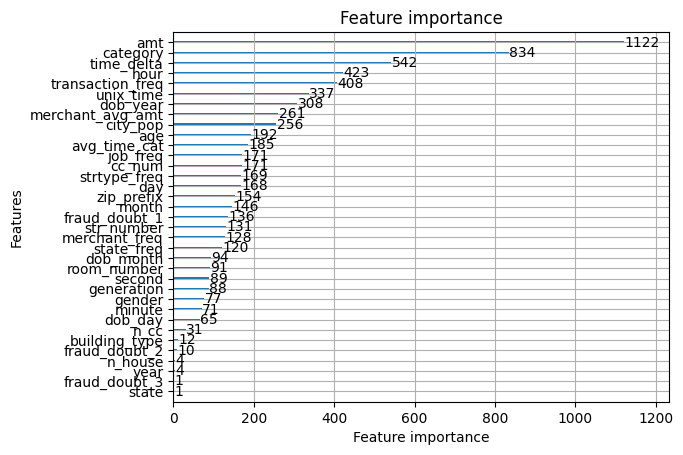

In [ ]:
# Define categorical columns (must be column names or indices)
categorical_cols = df_feature_select.select_dtypes(include=['object', 'category']).columns.tolist()

for col in categorical_cols:
    df_feature_select[col] = df_feature_select[col].astype("category")

X = df_feature_select.drop(columns=["is_fraud"])
y = df_feature_select["is_fraud"]

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-4,
    num_leaves=15,
    min_data_in_leaf=30,
    lambda_l1=5.0,
    lambda_l2=5.0,
    class_weight="balanced",
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42
)

# Train
lgbm.fit(
    X_train, y_train,
    categorical_feature=categorical_cols,
    eval_set=[(X_val, y_val)],
    eval_metric='aucpr', # or 'binary_logloss'
    callbacks=[early_stopping(stopping_rounds=50, verbose=True)]
)

# Predict
y_pred = lgbm.predict(X_val)

# Evaluate
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

# Feature importance
lgb.plot_importance(lgbm, max_num_features=X.shape[1])
plt.show()

In [ ]:
y_proba = lgbm.predict_proba(X_val)[:, 1]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0


In [ ]:
y_pred_thresh = (y_proba >= 0.7).astype(int)

print(confusion_matrix(y_val, y_pred_thresh))
print(classification_report(y_val, y_pred_thresh))

[[256674   1160]
 [    46   1455]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.56      0.97      0.71      1501

    accuracy                           1.00    259335
   macro avg       0.78      0.98      0.85    259335
weighted avg       1.00      1.00      1.00    259335



[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0


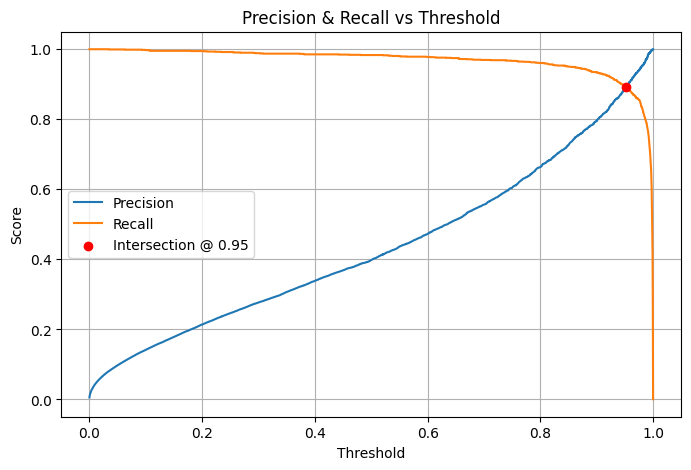

Intersection point threshold: 0.95, Precision=0.89, Recall=0.89


In [ ]:
# Probabilities for fraud class
y_proba = lgbm.predict_proba(X_val)[:, 1]

# Compute precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_val, y_proba)

# Find where |precision - recall| is minimal
diff = np.abs(precision[:-1] - recall[:-1])
idx = np.argmin(diff)
best_threshold = thresholds[idx]

# Plot
plt.figure(figsize=(8,5))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")

# Mark intersection point
plt.scatter(
    best_threshold, precision[idx],
    color="red", zorder=5, label=f"Intersection @ {best_threshold:.2f}"
)

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs Threshold")
plt.legend()
plt.grid()
plt.show()

print(f"Intersection point threshold: {best_threshold:.2f}, Precision={precision[idx]:.2f}, Recall={recall[idx]:.2f}")

In [ ]:
# Get feature importances
importances = pd.DataFrame({
    "feature": X_train.columns,
    "importance": lgbm.feature_importances_
}).sort_values(by="importance", ascending=False)

# Show top 20
print(importances.head(20))

             feature  importance
2                amt        1122
1           category         834
24        time_delta         542
10              hour         423
29  transaction_freq         408
6          unix_time         337
13          dob_year         308
26  merchant_avg_amt         261
5           city_pop         256
22               age         192
32      avg_time_cat         185
0             cc_num         171
28          job_freq         171
30      strtype_freq         169
9                day         168
21        zip_prefix         154
8              month         146
16     fraud_doubt_1         136
18        str_number         131
25     merchant_freq         128


In [ ]:
top_k = 20
top_features = importances.head(top_k)["feature"].tolist()

# Shorten dataset
X_train_top = X_train[top_features]
X_val_top = X_val[top_features]

# Build
lgbm_top = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    num_leaves=15,
    min_data_in_leaf=30,
    lambda_l1=5.0,
    lambda_l2=5.0,
    class_weight="balanced",
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42 )

# Train
lgbm_top.fit(
    X_train_top, y_train,
    categorical_feature=[f for f in top_features if f in categorical_cols],
    eval_set=[(X_val_top, y_val)],
    eval_metric='aucpr', # or 'binary_logloss'
    callbacks=[early_stopping(stopping_rounds=50, verbose=True)]
)

# Evaluate
y_pred_top = lgbm_top.predict(X_val_top)
print(confusion_matrix(y_val, y_pred_top))
print(classification_report(y_val, y_pred_top))

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.241289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3198
[LightGBM] [Info] Number of data points in the train set: 1037340, number 

In [ ]:
def top_features(n):
    top_features = importances.head(n)["feature"].tolist()
    return top_features

top_features = top_features(20)

In [ ]:
# y_proba2 = lgbm_top.predict_proba(X_val_top)[:, 1]

In [ ]:
# y_pred_thresh2 = (y_proba >= 0.91).astype(int)

# print(confusion_matrix(y_val, y_pred_thresh2))
# print(classification_report(y_val, y_pred_thresh2))

# Train Regressor

In [ ]:
# X_train = X_train[top_features]
# X_val = X_val[top_features]

In [ ]:
categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

# Convert to category dtype
for col in categorical_cols:
    X_train[col] = X_train[col].astype("category")

lgbm = LGBMClassifier(
    n_estimators=1000,         # increase due to lower learning rate
    learning_rate=0.05,        # slower learning → better generalization
    max_depth=4,                # limit tree depth
    num_leaves=15,              # ~2^max_depth, prevents overfitting
    min_child_samples=50,       # prevents tiny leaf nodes
    lambda_l1=5.0,
    lambda_l2=5.0,
    class_weight="balanced",    # handle imbalance
    subsample=0.7,              # row subsampling
    colsample_bytree=0.7,       # feature subsampling
    random_state=42,
)

# Train
lgbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
    categorical_feature=categorical_cols,
    callbacks=[early_stopping(stopping_rounds=50, verbose=True)]
)

[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.485097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3694
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 35
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Info

LGBMClassifier(class_weight='balanced', colsample_bytree=0.7, lambda_l1=5.0,
               lambda_l2=5.0, learning_rate=0.05, max_depth=4,
               min_child_samples=50, n_estimators=1000, num_leaves=15,
               random_state=42, subsample=0.7)

In [ ]:
# class LGBMWithThreshold:
#     def __init__(self, model, threshold=0.5):
#         self.model = model
#         self.threshold = threshold

#     def predict(self, X):
#         proba = self.model.predict_proba(X)[:, 1]
#         return (proba >= self.threshold).astype(int)

#     def predict_proba(self, X):
#         return self.model.predict_proba(X)

In [ ]:
# clf = LGBMWithThreshold(model, threshold=0.65)
# y_pred = clf.predict(X_test)

# Preprocess test set

In [ ]:
df_test = pd.read_csv("fraudTest.csv")

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  int64  
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                   555719 non-nu

In [ ]:
df_test = df_test.drop('Unnamed: 0', axis=1)

In [ ]:
df_test["trans_date_trans_time"] = pd.to_datetime(df_test["trans_date_trans_time"])
df_test["year"] = df_test["trans_date_trans_time"].dt.year
df_test["month"] = df_test["trans_date_trans_time"].dt.month
df_test["day"] = df_test["trans_date_trans_time"].dt.day
df_test["hour"] = df_test["trans_date_trans_time"].dt.hour
df_test["minute"] = df_test["trans_date_trans_time"].dt.minute
df_test["second"] = df_test["trans_date_trans_time"].dt.second

In [ ]:
df_test["dob"] = pd.to_datetime(df_test["dob"])
df_test["dob_year"] = df_test["dob"].dt.year
df_test["dob_month"] = df_test["dob"].dt.month
df_test["dob_day"] = df_test["dob"].dt.day

In [ ]:
# Create binary feature
df_test["fraud_doubt_1"] = df_test["hour"].apply(
    lambda h: 1 if (h >= 22 or h <= 3) else 0
)

In [ ]:
df_test = df_test.sort_values(by=["cc_num", "trans_date_trans_time"])
df_test["time_delta"] = df_test.groupby("cc_num")["trans_date_trans_time"].diff().dt.total_seconds() / 3600

In [ ]:
df_test["customer_name"] = df_test["first"].str.cat(df_test["last"], sep=' ')

In [ ]:
df_test["generation"] = df_test["dob_year"].apply(assign_generation)

In [ ]:
df_test["month"].unique()

array([ 6,  7,  8,  9, 10, 11, 12], dtype=int32)

In [ ]:
df_test["time_delta"] = df_test["time_delta"].fillna(0)

In [ ]:
splits = df_test["street"].str.split(" ", expand=True)

# Assign to new columns sequentially
df_test["str_number"]    = splits[0]
df_test["str_name"]      = splits[1]
df_test["str_type"]      = splits[2]
df_test["building_type"] = splits[3]
df_test["room_number"]   = splits[4]

df_test = df_test.drop('street', axis=1)

In [ ]:
df_test["room_number"] = df_test["room_number"].fillna(0)
df_test["str_number"] = df_test["str_number"].astype(int)
df_test["room_number"]  = df_test["room_number"] .astype(int)

In [ ]:
df_test["building_type"] = df_test["building_type"].replace({None: "House"})

In [ ]:
df_test["zip"] = df_test["zip"].astype(str).str.zfill(5)

# Extract first 3 digits (ZIP prefix / metro area)
df_test["zip_prefix"] = df_test["zip"].str[:3]
df_test["zip_prefix"] = df_test["zip_prefix"].astype(int)

In [ ]:
df_test["job"] = df_test["job"].str.split(",").str[0].str.strip()

In [ ]:
df_test["age"] = df_test["year"] - df_test["dob_year"]

In [ ]:
df_test["n_cc"] = df_test.groupby("customer_name")["cc_num"].transform("nunique")

In [ ]:
df_test["trans_date_trans_time"] = pd.to_datetime(df_test["trans_date_trans_time"])

# Create a new column with unix_time (seconds since epoch)
df_test["unix_time"] = df_test["trans_date_trans_time"].astype(int) // 10**9

In [ ]:
# Select only numeric features
num_cols = df_test.select_dtypes(include=['int64', 'float64']).columns

# Compute skewness for each numeric column
skewness = df_test[num_cols].apply(lambda x: skew(x.dropna()))
skewness = skewness.sort_values(ascending=False)

print(skewness)

amt              37.133977
is_fraud         16.002510
n_cc              8.206144
city_pop          5.583400
time_delta        4.189306
cc_num            2.849196
str_number        1.957505
fraud_doubt_1     1.255384
room_number       0.952574
zip_prefix        0.077376
unix_time        -0.077405
merch_lat        -0.202626
lat              -0.206037
merch_long       -1.136806
long             -1.139413
dtype: float64


In [ ]:
df_test["amt"] = np.log1p(df_test["amt"])   # log(amt+1)

In [ ]:
df_test = flag2.transform(df_test)

In [ ]:
df_test = flag3.transform(df_test)

In [ ]:
# east_states = {
#     "ME","NH","VT","MA","RI","CT","NY","NJ","PA","DE","MD","VA","NC","SC",
#     "GA","FL","WV","OH","IN","MI","KY","TN","AL","MS"
# }

# west_states = {
#     "WA","OR","CA","NV","ID","MT","WY","UT","CO","AZ","NM","AK","HI"
# }

# # everything not in east/west can be considered "Central" if you want
# df_test["state"] = df_test["state"].apply(
#     lambda x: "East" if x in east_states else ("West" if x in west_states else "Central")
# )

In [ ]:
df_test["building_type"].unique()

array(['House', 'Apt.', 'Suite'], dtype=object)

In [ ]:
# category_buckets = {
#     "Essentials": ["grocery_pos", "grocery_net", "food_dining"],
#     "Home": ["home", "gas_transport", "misc_net", "misc_pos"],
#     "Lifestyle": ["personal_care", "health_fitness", "kids_pets"],
#     "Entertaiment": ["shopping_net", "shopping_pos", "entertainment", "travel"]
# }

# def bucket_category(cat):
#     for bucket, values in category_buckets.items():
#         if cat in values:
#             return bucket
#     return "Other"

# df_test["category"] = df_test["category"].apply(bucket_category)

In [ ]:
df_test["merchant_freq"] = df_test["merchant"].map(df_test["merchant"].value_counts())

# Average transaction amount per merchant
merchant_avg = df_test.groupby("merchant")["amt"].mean()
df_test["merchant_avg_amt"] = df_test["merchant"].map(merchant_avg)

In [ ]:
df_test["state_freq"] = df_test["state"].map(df_test["state"].value_counts())

In [ ]:
df_test["job_freq"] = df_test["job"].map(df_test["job"].value_counts())

In [ ]:
df_test["transaction_freq"] = df_test["customer_name"].map(df_test["customer_name"].value_counts())

In [ ]:
df_test["strtype_freq"] = df_test["str_type"].map(df_test["str_type"].value_counts())

In [ ]:
df_test["n_house"] = (
    df_test.groupby("customer_name")["str_name"].transform("nunique")
)

In [ ]:
# # Haversine function assumed to be defined
# street_thresh_hr = 10 / 60  # 10 min → 0.1667 hr
# city_thresh_hr = 30 / 60    # 30 min → 0.5 hr
# avg_speed = 90              # km/h

# # Compute distance and speed
# distance = haversine_vectorized(
#     df_test.groupby("cc_num")["lat"].shift(1),
#     df_test.groupby("cc_num")["long"].shift(1),
#     df_test["lat"],
#     df_test["long"]
# )
# df_test["speed_kmh"] = distance / df_test["time_delta"].replace(0, np.nan)

# # Flags
# df_test["str_shifted"] = ((df_test["str_name"] != df_test.groupby("cc_num")["str_name"].shift(1)) &
#                               (df_test["time_delta"] < street_thresh_hr)).astype(int)

# df_test["city_shifted"] = ((df_test["city_pop"] != df_test.groupby("cc_num")["city_pop"].shift(1)) &
#                                (df_test["time_delta"] < city_thresh_hr)).astype(int)

# df_test["speed_flag"] = ((df_test["speed_kmh"] > avg_speed) &
#                              ((df_test["str_shifted"] == 1) | (df_test["city_shifted"] == 1))).astype(int)

In [ ]:
# customer_stats = df_test.groupby("customer_name").agg(
#     total_transactions=("trans_num", "count"),
#     total_amt=("amt", "sum")
# ).reset_index()

# median_transactions = customer_stats["total_transactions"].median()
# median_amt = customer_stats["total_amt"].median()

# customer_stats["fraud_doubt_4"] = np.where(
#     (customer_stats["total_transactions"] <= median_transactions) &
#     (customer_stats["total_amt"] <= median_amt),
#     1,  # flagged as suspicious
#     0   # not flagged
# )

# df_test = df_test.merge(
#     customer_stats[["customer_name", "fraud_doubt_4"]],
#     on="customer_name",
#     how="left"
# )

In [ ]:
df_test = df_test.drop(["trans_date_trans_time", "merchant", "first", "last", "job", "city", "zip", "lat", "long", "dob", "trans_num", "merch_lat", "merch_long", "customer_name", "str_name", "mode_strname_cat", "str_type"], axis=1)

In [ ]:
X_test = df_test.drop(columns=["is_fraud"])
# X_test = X_test[top_features]
y_test = df_test["is_fraud"]

In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 555719 entries, 157 to 553883
Data columns (total 35 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cc_num            555719 non-null  int64  
 1   category          555719 non-null  object 
 2   amt               555719 non-null  float64
 3   gender            555719 non-null  object 
 4   state             555719 non-null  object 
 5   city_pop          555719 non-null  int64  
 6   unix_time         555719 non-null  int64  
 7   year              555719 non-null  int32  
 8   month             555719 non-null  int32  
 9   day               555719 non-null  int32  
 10  hour              555719 non-null  int32  
 11  minute            555719 non-null  int32  
 12  second            555719 non-null  int32  
 13  dob_year          555719 non-null  int32  
 14  dob_month         555719 non-null  int32  
 15  dob_day           555719 non-null  int32  
 16  fraud_doubt_1     55571

In [ ]:
categorical_cols

['category', 'gender', 'state', 'generation', 'building_type']

[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
Confusion Matrix:
 [[504165  49409]
 [    62   2083]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.91      0.95    553574
           1       0.04      0.97      0.08      2145

    accuracy                           0.91    555719
   macro avg       0.52      0.94      0.52    555719
weighted avg       1.00      0.91      0.95    555719

ROC AUC: 0.9850301877716459
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_a

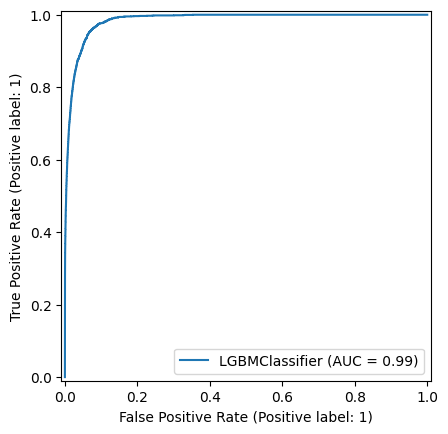

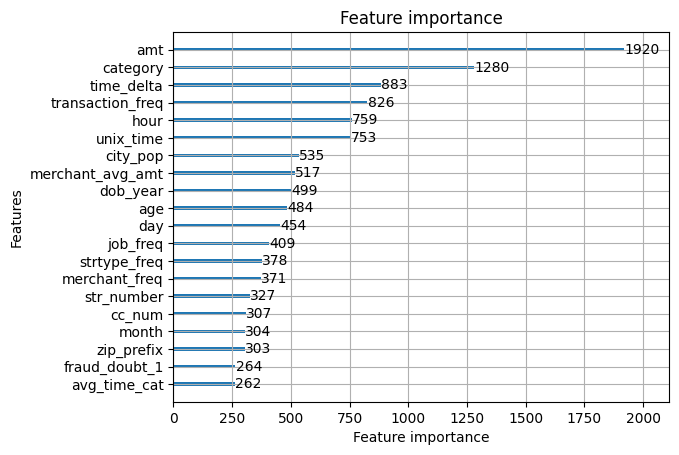

In [ ]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay

categorical_cols = X_test.select_dtypes(include=["object", "category"]).columns.tolist()

# Convert to category dtype
for col in categorical_cols:
    X_test[col] = X_test[col].astype("category")

y_pred = lgbm.predict(X_test)
y_proba = lgbm.predict_proba(X_test)[:, 1]

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# ROC Curve
RocCurveDisplay.from_estimator(lgbm, X_test, y_test)
plt.show()

# Feature importance
lgb.plot_importance(lgbm, max_num_features=20)
plt.show()

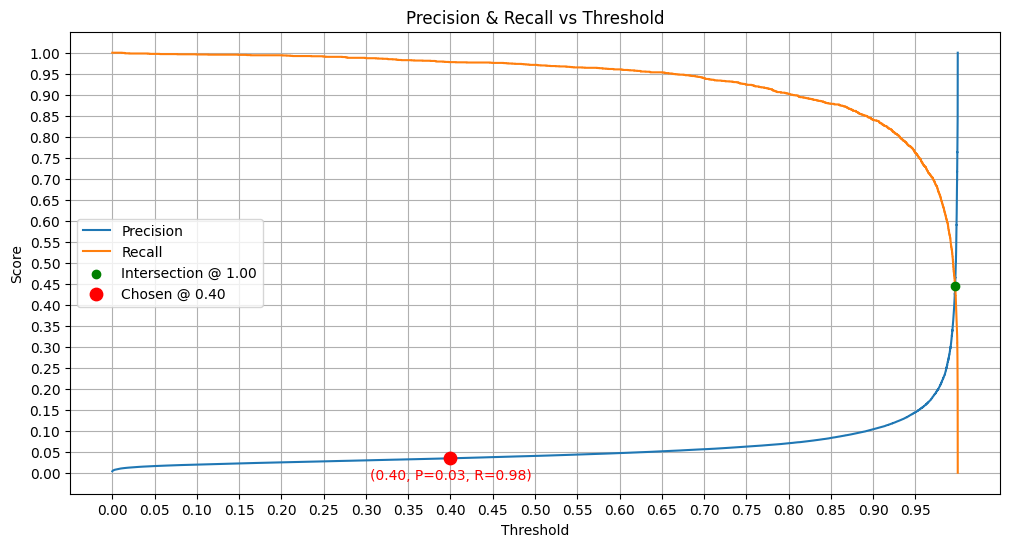

Intersection point threshold: 1.00, Precision=0.45, Recall=0.45
Chosen threshold: 0.40, Precision=0.03, Recall=0.98


In [ ]:
# Compute precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Find where |precision - recall| is minimal
diff = np.abs(precision[:-1] - recall[:-1])
idx = np.argmin(diff)
best_threshold = thresholds[idx]

# --- 👇 Manually choose a threshold to annotate ---
chosen_threshold = 0.40   # <-- change this to your target threshold
chosen_idx = (np.abs(thresholds - chosen_threshold)).argmin()
chosen_precision = precision[chosen_idx]
chosen_recall = recall[chosen_idx]

# Plot
plt.figure(figsize=(12,6))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")

# Mark best intersection point
plt.scatter(
    best_threshold, precision[idx],
    color="green", zorder=5, label=f"Intersection @ {best_threshold:.2f}"
)

# Mark chosen threshold
plt.scatter(
    chosen_threshold, chosen_precision,
    color="red", s=80, zorder=6, label=f"Chosen @ {chosen_threshold:.2f}"
)

# Annotate coordinates
plt.text(chosen_threshold, chosen_precision - 0.05,
         f"({chosen_threshold:.2f}, P={chosen_precision:.2f}, R={chosen_recall:.2f})",
         color="red", fontsize=10, ha="center")

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs Threshold")
plt.legend()
plt.grid()

# 👇 Set ticks for better detail
plt.xticks(np.arange(0, 1, 0.05))
plt.yticks(np.arange(0, 1.05, 0.05))

plt.show()

print(f"Intersection point threshold: {best_threshold:.2f}, "
      f"Precision={precision[idx]:.2f}, Recall={recall[idx]:.2f}")
print(f"Chosen threshold: {chosen_threshold:.2f}, "
      f"Precision={chosen_precision:.2f}, Recall={chosen_recall:.2f}")

In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc

# # Predict probabilities
# y_val_prob = lgbm.predict_proba(X_val)[:, 1]
# y_test_prob = lgbm.predict_proba(X_test)[:, 1]

# # Apply threshold (default 0.5 or custom)
# threshold = 0.2
# y_val_pred = (y_val_prob >= threshold).astype(int)
# y_test_pred = (y_test_prob >= threshold).astype(int)

# # Confusion matrices
# print("Validation set:")
# print(confusion_matrix(y_val, y_val_pred))
# print(classification_report(y_val, y_val_pred))

# print("\nTest set:")
# print(confusion_matrix(y_test, y_test_pred))
# print(classification_report(y_test, y_test_pred))